---

This project involves analyzing and processing logistics data from Delhivery. The primary goal is to clean, sanitize, and manipulate the data to extract useful features for further analysis and modeling.

### Objectives:
1. Clean and preprocess the raw data to handle missing values, outliers, and inconsistencies.
2. Extract relevant features from the data, such as city, place code, and state from the source and destination names.
3. Aggregate data based on unique trip identifiers to facilitate comprehensive analysis.
4. Perform exploratory data analysis (EDA) to understand the distribution of data and identify key patterns.
5. Visualize the data to identify trends, outliers, and relationships between various features.
6. Normalize and standardize numerical features for consistency and model readiness.
7. One-hot encode categorical variables to enable their use in machine learning models.

### Methodology:
- Use pandas for data manipulation and preprocessing.
- Handle missing values by analyzing the percentage of missing data and deciding on appropriate imputation or removal strategies.
- Split source and destination names to extract meaningful features.
- Aggregate data using groupby operations to analyze trip-level information.
- Visualize data using matplotlib and seaborn to gain insights into the distribution and relationships of features.
- Apply standardization and normalization techniques to prepare data for modeling.

### Dataset:
The dataset contains various columns such as trip creation time, route type, source and destination information, trip duration, distance, and more. It is essential to clean and preprocess this data to make it suitable for analysis and model building.

### Expected Outcomes:
- A clean and well-processed dataset ready for further analysis and modeling.
- Insights into the key logistics hubs and routes for Delhivery.
- Visualizations and analysis that highlight important trends and patterns in the logistics data.
- Recommendations for improving logistics operations based on the analysis.

---

> Import all required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



> Fetch Data form provided url into a Pandas DataFrame





In [ ]:
!pip install gdown
import gdown

url = r'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181'
output = 'delhivery_data.csv'
gdown.download(url, output, quiet=False)
df = pd.read_csv('delhivery_data.csv')

Downloading...
From: https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181
To: /content/delhivery_data.csv
100%|██████████| 55.6M/55.6M [00:00<00:00, 98.1MB/s]


> Check for missing values



In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data_summary)

                                Missing Values  Percentage
data                                         0    0.000000
trip_creation_time                           0    0.000000
route_schedule_uuid                          0    0.000000
route_type                                   0    0.000000
trip_uuid                                    0    0.000000
source_center                                0    0.000000
source_name                                293    0.202254
destination_center                           0    0.000000
destination_name                           261    0.180165
od_start_time                                0    0.000000
od_end_time                                  0    0.000000
start_scan_to_end_scan                       0    0.000000
is_cutoff                                    0    0.000000
cutoff_factor                                0    0.000000
cutoff_timestamp                             0    0.000000
actual_distance_to_destination               0    0.0000



> Decide on handling missing values based on the summary

> For simplicity, we will fill missing values for columns with less than 30% missing data using forward fill

> Columns with more than 30% missing data might need different handling strategies



In [ ]:
columns_to_fill = missing_data_summary[missing_data_summary['Percentage'] < 30].index
columns_to_drop = missing_data_summary[missing_data_summary['Percentage'] >= 30].index

df[columns_to_fill] = df[columns_to_fill].fillna(method='ffill')
df.drop(columns=columns_to_drop, inplace=True)

# Data Structure Analysis
print(df.shape)
print(df.dtypes)
print(df.describe())

(144867, 24)
data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor       


> Convert 'route_type' column to categorical data type as it optimizes memory usage and prepares the data for efficient categorical operations



In [ ]:
df['route_type'] = df['route_type'].astype('category')
print(df['route_type'])

0         Carting
1         Carting
2         Carting
3         Carting
4         Carting
           ...   
144862    Carting
144863    Carting
144864    Carting
144865    Carting
144866    Carting
Name: route_type, Length: 144867, dtype: category
Categories (2, object): ['Carting', 'FTL']


---
> # Visual Analysis

> Distribution plots of continuous variables


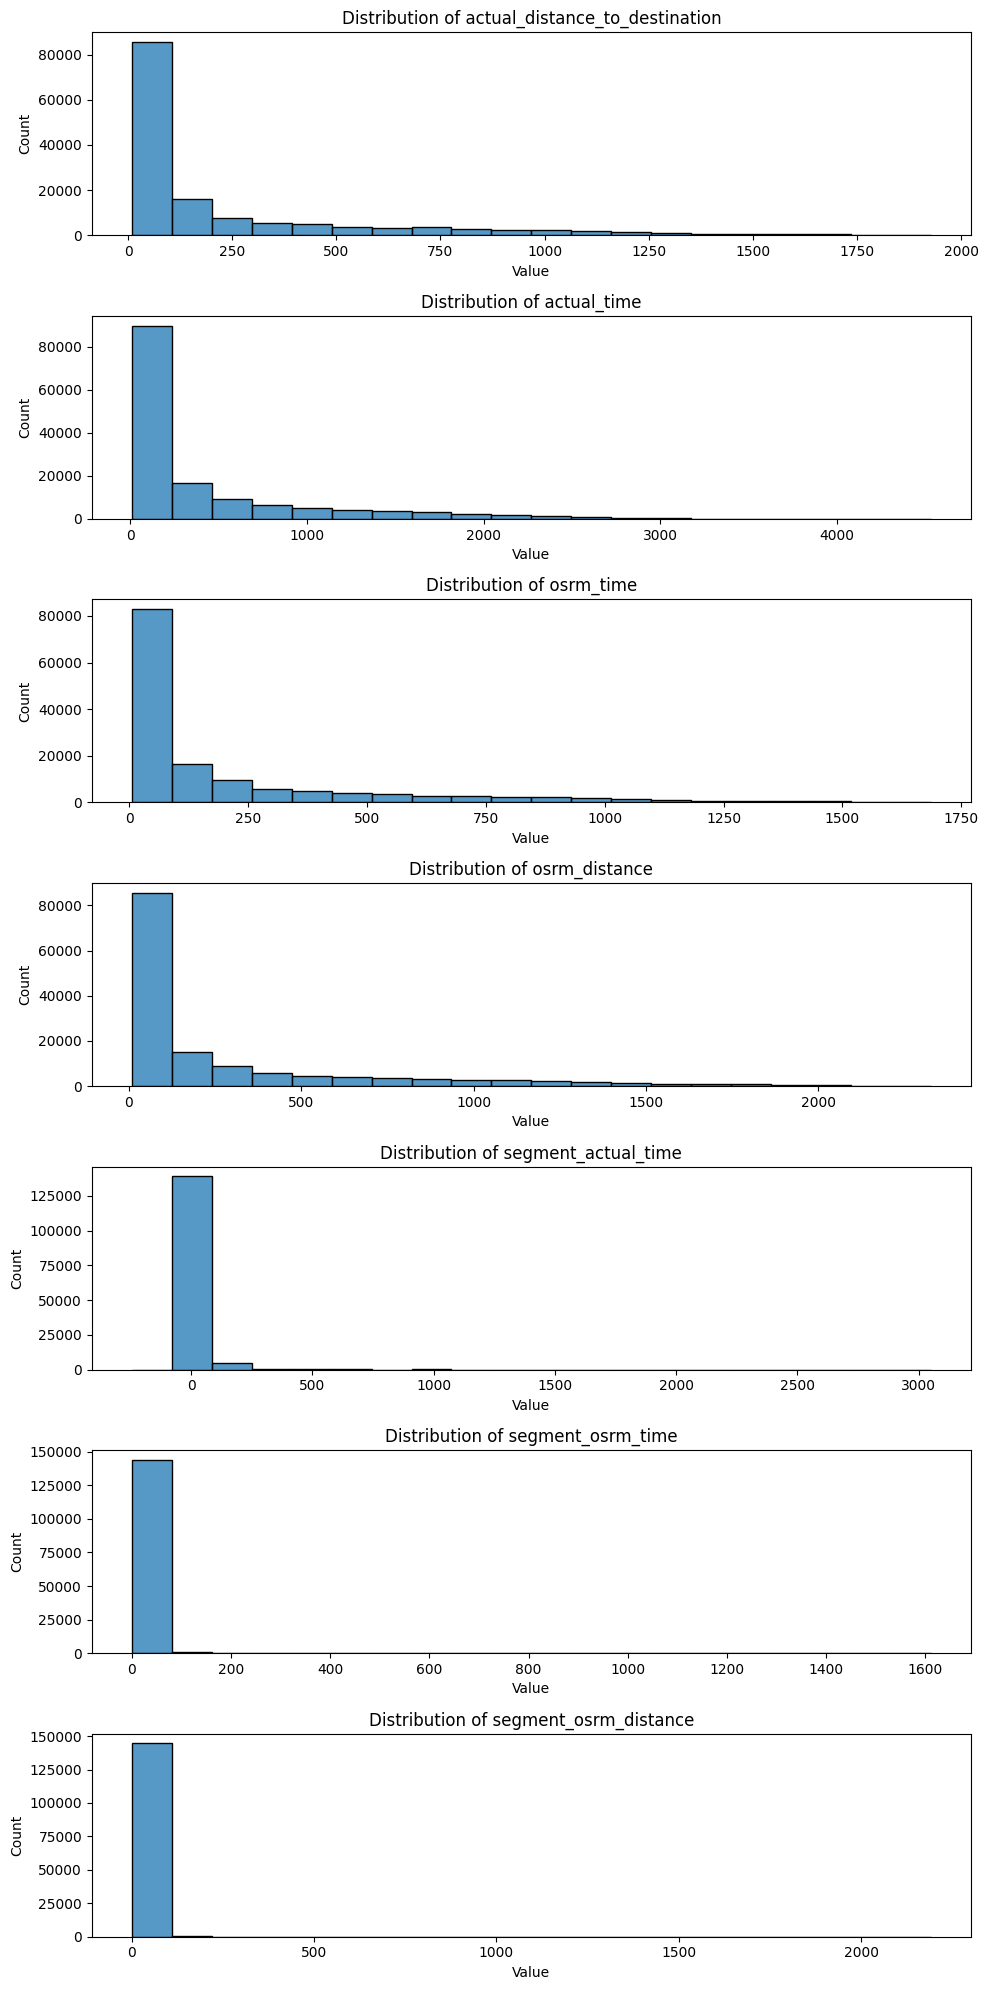

In [ ]:
continuous_vars = ['actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance']
# for var in continuous_vars:
#     sns.histplot(df[var])
#     plt.title(f'Distribution of {var}')
#     plt.show()
# Calculating mean values for each variable
mean_values = df[continuous_vars].mean()
fig, axes = plt.subplots(nrows=len(continuous_vars), figsize=(10, 20))

# Loop through each variable and plot its distribution
for idx, var in enumerate(continuous_vars):
    sns.histplot(df[var], ax=axes[idx], bins=20)  # Adjust bins as needed
    axes[idx].set_title(f'Distribution of {var}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

> Box plots of categorical variables

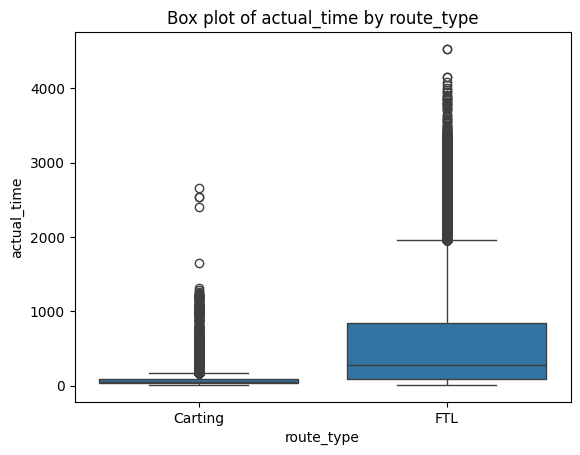

In [ ]:
sns.boxplot(x='route_type', y='actual_time', data=df)
plt.title('Box plot of actual_time by route_type')
plt.show()


# Feature Creation
> Extracting features from trip_creation_time

In [ ]:
df['trip_creation_time'] = pd.to_datetime(df['trip_creation_time'])
df['trip_creation_month'] = df['trip_creation_time'].dt.month
df['trip_creation_year'] = df['trip_creation_time'].dt.year
df['trip_creation_day'] = df['trip_creation_time'].dt.day

> Splitting source and destination names with filling

In [ ]:
df['source_split'] = df['source_name'].str.split('-', n=2)
df['destination_split'] = df['destination_name'].str.split('-', n=2)

df['source_city'] = df['source_split'].apply(lambda x: x[0] if len(x) > 0 else '')
df['source_place_code'] = df['source_split'].apply(lambda x: x[1] if len(x) > 1 else '')
df['source_state'] = df['source_split'].apply(lambda x: x[2] if len(x) > 2 else '')

df['destination_city'] = df['destination_split'].apply(lambda x: x[0] if len(x) > 0 else '')
df['destination_place_code'] = df['destination_split'].apply(lambda x: x[1] if len(x) > 1 else '')
df['destination_state'] = df['destination_split'].apply(lambda x: x[2] if len(x) > 2 else '')

In [ ]:
df.drop(['source_split', 'destination_split'], axis=1, inplace=True)

## Aggregation
> Summarizing trip data by unique identifiers

In [ ]:
aggregated_df = df.groupby(['trip_uuid', 'source_center', 'destination_center']).agg({
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'trip_creation_time': 'first',
    'route_type': 'first',
    'source_city': 'first',
    'source_place_code': 'first',
    'source_state': 'first',
    'destination_city': 'first',
    'destination_place_code': 'first',
    'destination_state': 'first'
}).reset_index()

> #### Calculate time taken between od_start_time and od_end_time

In [ ]:
df['od_start_time'] = pd.to_datetime(df['od_start_time'])
df['od_end_time'] = pd.to_datetime(df['od_end_time'])

> #### Calculate time taken for each trip in seconds

In [ ]:
df['time_taken'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds()

### Hypothesis Testing and Visual Analysis

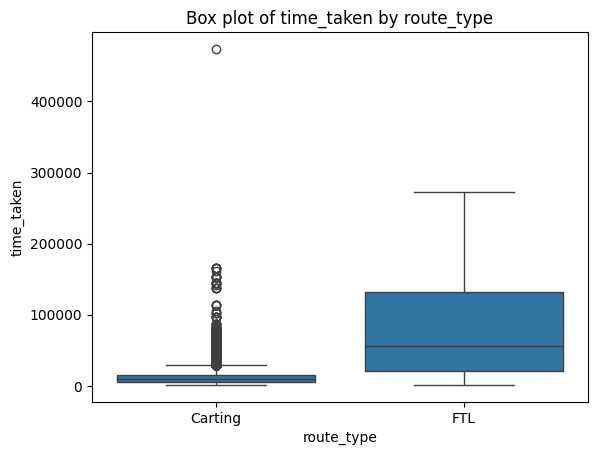

In [ ]:
sns.boxplot(x='route_type', y='time_taken', data=df)
plt.title('Box plot of time_taken by route_type')
plt.show()

### Outlier Detection


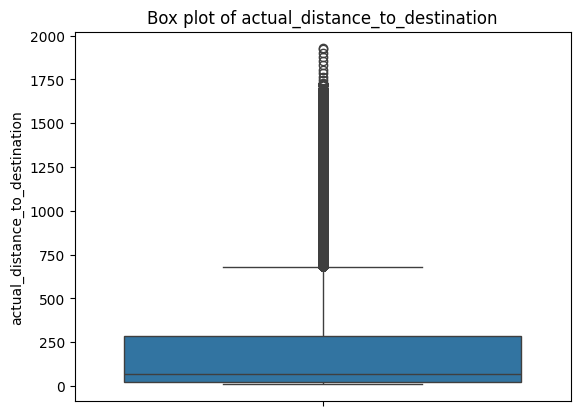

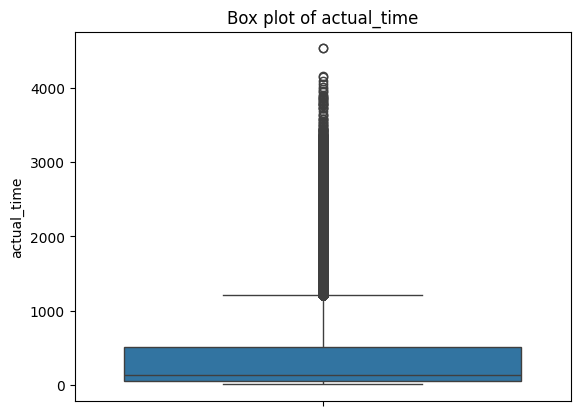

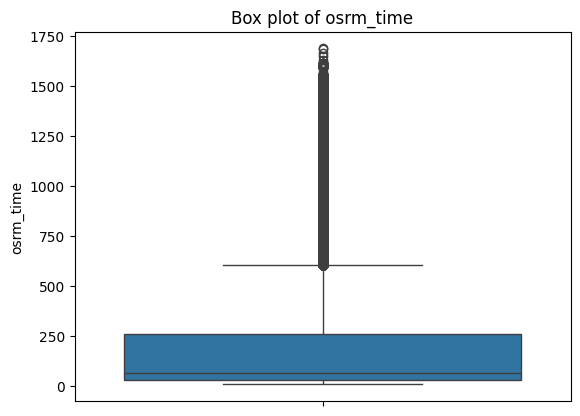

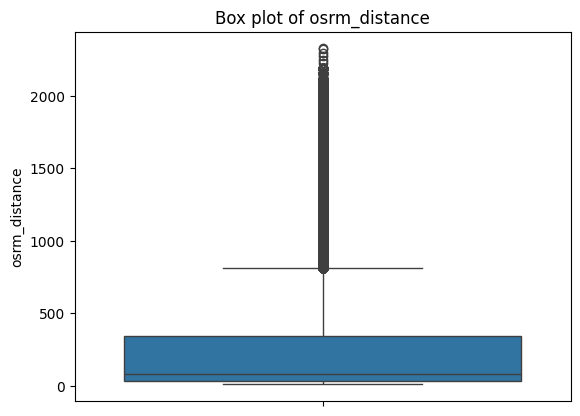

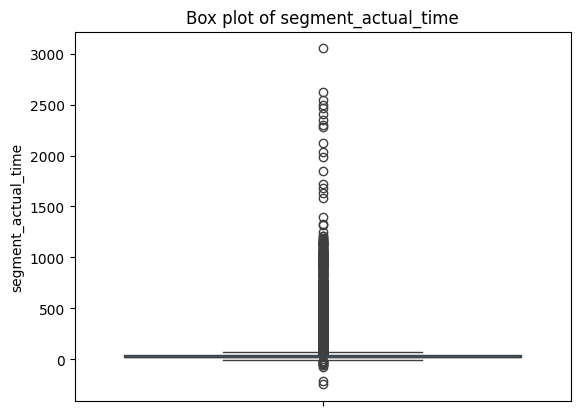

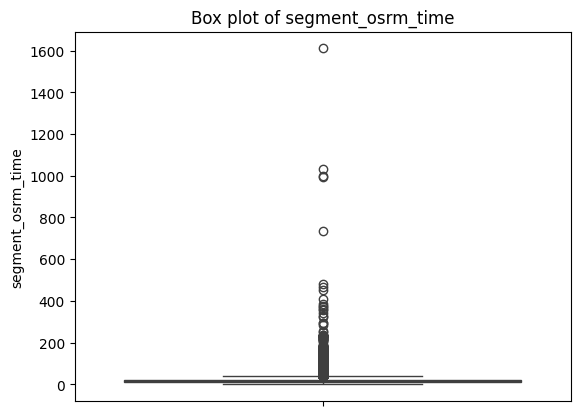

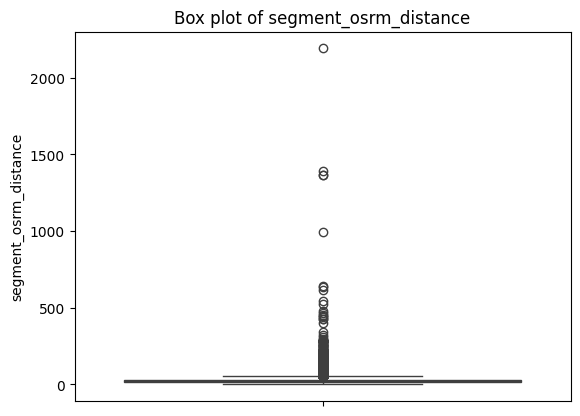

In [ ]:
for var in continuous_vars:
    sns.boxplot(df[var])
    plt.title(f'Box plot of {var}')
    plt.show()

### Outlier Treatment using IQR


In [ ]:
for var in continuous_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[var] = np.where(df[var] < lower_bound, lower_bound, df[var])
    df[var] = np.where(df[var] > upper_bound, upper_bound, df[var])

### One-hot Encoding of categorical variables


In [ ]:
df = pd.get_dummies(df, columns=['route_type'])

### Normalization/Standardization


In [ ]:
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

### Correlation Matrix

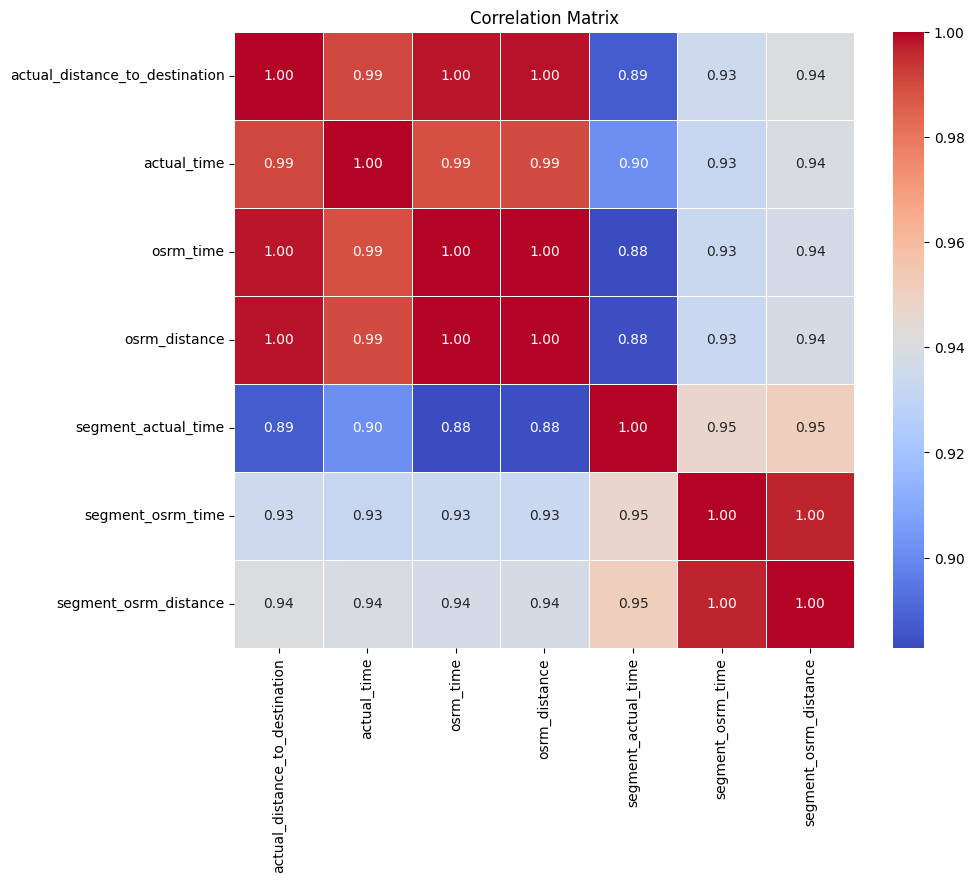

In [ ]:
# Selecting only the numeric columns for correlation matrix
numeric_columns = aggregated_df.select_dtypes(include=['number'])

# Computing the correlation matrix
corr_matrix = numeric_columns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## **Business Insights**
### Top cities as source of trip

In [ ]:
print("Top 5 source cities by number of trips:")
print(df['source_city'].value_counts().head())

Top 5 source cities by number of trips:
source_city
Gurgaon_Bilaspur_HB (Haryana)        23402
Bangalore_Nelmngla_H (Karnataka)      9977
Bhiwandi_Mankoli_HB (Maharashtra)     9090
Pune_Tathawde_H (Maharashtra)         4061
Hyderabad_Shamshbd_H (Telangana)      3340
Name: count, dtype: int64


### Top cities as destination of trip

In [ ]:
print("Top 5 destination cities by number of trips:")
print(df['destination_city'].value_counts().head())

Top 5 destination cities by number of trips:
destination_city
Gurgaon_Bilaspur_HB (Haryana)        15196
Bangalore_Nelmngla_H (Karnataka)     11019
Bhiwandi_Mankoli_HB (Maharashtra)     5510
Hyderabad_Shamshbd_H (Telangana)      5142
Kolkata_Dankuni_HB (West Bengal)      4892
Name: count, dtype: int64


## **Insights**


Based on the analysis of the top 5 source and destination cities by the number of trips, several insights and deductions can be made:

1. **Gurgaon_Bilaspur_HB (Haryana) is the Major Hub**:
   - **Source City**: Gurgaon_Bilaspur_HB (Haryana) is the most frequent source city, accounting for 23,402 trips.
   - **Destination City**: Gurgaon_Bilaspur_HB (Haryana) is also the most common destination city with 15,196 trips.
   - **Inference**: This indicates that Gurgaon_Bilaspur_HB (Haryana) is a critical hub in the network, likely a central distribution point for Delhivery.

2. **Bangalore_Nelmngla_H (Karnataka) is a Key Node**:
   - **Source City**: Bangalore_Nelmngla_H (Karnataka) ranks second as a source city with 9,977 trips.
   - **Destination City**: It is the second most common destination city with 11,019 trips.
   - **Inference**: Bangalore_Nelmngla_H (Karnataka) serves as a significant node in the logistics network, possibly a regional hub for southern India.

3. **Bhiwandi_Mankoli_HB (Maharashtra)**:
   - **Source City**: Bhiwandi_Mankoli_HB (Maharashtra) ranks third among source cities with 9,090 trips.
   - **Destination City**: It is the third most common destination city with 5,510 trips.
   - **Inference**: Bhiwandi_Mankoli_HB (Maharashtra) is a major logistics center, possibly catering to the western region of India.

4. **Hyderabad_Shamshbd_H (Telangana)**:
   - **Source City**: Hyderabad_Shamshbd_H (Telangana) is the fourth most common source city with 3,340 trips.
   - **Destination City**: It ranks fourth among destination cities with 5,142 trips.
   - **Inference**: Hyderabad_Shamshbd_H (Telangana) is an important location, likely handling a significant volume of cargo for the central-southern region.

5. **Pune_Tathawde_H (Maharashtra) and Kolkata_Dankuni_HB (West Bengal)**:
   - **Source City**: Pune_Tathawde_H (Maharashtra) is the fifth most common source city with 4,061 trips.
   - **Destination City**: Kolkata_Dankuni_HB (West Bengal) is the fifth most common destination city with 4,892 trips.
   - **Inference**: Pune_Tathawde_H (Maharashtra) and Kolkata_Dankuni_HB (West Bengal) are significant nodes, likely servicing their respective regional areas.



---



### Deductions

1. **Strategic Importance of Certain Cities**:
   - The high frequency of trips to and from cities like Gurgaon_Bilaspur_HB (Haryana) and Bangalore_Nelmngla_H (Karnataka) suggests these locations are crucial for Delhivery's logistics operations. These cities might house major warehouses, sorting centers, or distribution hubs.

2. **Regional Distribution Network**:
   - The distribution of top source and destination cities indicates a well-spread network across various regions—north (Gurgaon), south (Bangalore, Hyderabad), west (Bhiwandi, Pune), and east (Kolkata). This regional distribution suggests an efficient network designed to cover the major demand centers across India.

3. **Potential for Optimization**:
   - Given the high volume of trips involving these key cities, there may be opportunities to further optimize logistics operations in these areas. For example, enhancing route planning, increasing the capacity of warehouses, or improving last-mile delivery efficiency could provide significant gains.

4. **Business Focus Areas**:
   - The insights point towards key areas where Delhivery could focus its efforts to further strengthen its network. For instance, investing in infrastructure in Gurgaon_Bilaspur_HB (Haryana) and Bangalore_Nelmngla_H (Karnataka) could yield high returns given their central roles in the logistics network.

5. **Performance Monitoring**:
   - Regular monitoring and analysis of the trip data can help identify trends, peak periods, and any potential bottlenecks. This proactive approach can ensure timely interventions and continuous improvement in logistics operations.


---



### Correlation Analysis Insights

From the correlation matrix, we observed:

1. **High Correlation Between Distances and Times**:
   - Metrics such as `actual_distance_to_destination`, `actual_time`, `osrm_time`, `osrm_distance`, `segment_actual_time`, `segment_osrm_time`, and `segment_osrm_distance` are highly correlated. This indicates that as one distance or time metric increases, the others increase proportionally.

2. **Consistency in OSRM Metrics**:
   - The near-perfect correlation between `osrm_time` and `osrm_distance`, as well as `segment_osrm_time` and `segment_osrm_distance`, shows that the OSRM-predicted times and distances are consistently proportional.

3. **Alignment of Actual and Predicted Metrics**:
   - The strong correlation between actual metrics (`actual_distance_to_destination`, `actual_time`) and OSRM-predicted metrics (`osrm_time`, `osrm_distance`) suggests that the actual recorded travel data is closely aligned with the OSRM predictions.

4. **Segment Metrics Reliability**:
   - High correlations within segment metrics indicate reliability and consistency in the travel data across different segments.



---



### Recommendations

1. **Enhance Infrastructure in Key Hubs**:
   - Invest in upgrading and expanding facilities in Gurgaon_Bilaspur_HB (Haryana) and Bangalore_Nelmngla_H (Karnataka) to support the high volume of trips.

2. **Optimize Route Planning**:
   - Utilize advanced route optimization techniques to reduce travel time and increase efficiency, especially for the most frequent routes.

3. **Increase Capacity and Efficiency**:
   - Increase the capacity and operational efficiency of logistics centers in Bhiwandi_Mankoli_HB (Maharashtra), Hyderabad_Shamshbd_H (Telangana), and other major nodes.

4. **Regular Data Analysis**:
   - Continuously analyze logistics data to identify patterns, predict demand, and make data-driven decisions for improving operations.

5. **Focus on Regional Hubs**:
   - Strengthen regional hubs to ensure quick and efficient distribution to surrounding areas, reducing overall delivery times.

By implementing these recommendations, Delhivery can further enhance its logistics operations.


---



In [ ]:
print("By implementing these recommendations, Delhivery can further enhance its logistics operations.")

By implementing these recommendations, Delhivery can further enhance its logistics operations.
